In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')

import os
import sys
# add the src folder to the python path
sys.path.append(os.path.abspath('../src'))
from data_loader import load_data

In [3]:
# load the data
csv_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = load_data(csv_url)
df.head()

Detected encoding: ascii


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
# check for missing values
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

Sunshine and cloud cover seem like important features, but they have a lot of missing values, far too many to impute their missing values.

#### Drop all rows with missing values
To try to keep things simple we'll drop rows with missing values and see what's left

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

Since we still have 56k observations left after dropping missing values, we may not need to impute any missing values.

In [6]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

#### Data leakage considerations
Consider the descriptions above for the columns in the data set. Are there any practical limitations to being able to predict whether it will rain tomorrow given the available data?

If we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday, then we can legitimately utilize all of the available features. 

With this new target, we should update the names of the rain columns accordingly to avoid confusion.

In [7]:
df = df.rename(columns={'RainToday': 'RainYesterday', 
                        'RainTomorrow': 'RainToday'})

#### Data Granularity

Would the weather patterns have the same predictability in vastly different locations in Australia? I would think not.
The chance of rain in one location can be much higher than in another. Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.

#### Location selection

You could do some research to group cities in the Location column by distance, which I've done for you behind the scenes.
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.
Let's group these three locations together and use only their weather data to build our localized prediction model.
Because there might still be some slight variations in the weather patterns we'll keep Location as a categorical variable.

In [8]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

#### Extracting a seasonality feature
Now consider the Date column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.
There may be some variation with Year as well, but we'll leave that out for now. Let's engineer a Season feature from Date and drop Date afterward, since it is most likely less informative than season. An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the Date column.

In [9]:
# Create a function to map dates to seasons
def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'
    

Map the dates to seasons and drop the Date column

In [10]:
# map the dates to seasons
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df = df.drop(columns=['Date'])
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer


In [11]:
# Define feature and target dataframes
X = df.drop(columns=['RainToday'])
y = df['RainToday']

In [12]:
# Check class balance
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

### Interpretation
Total = 5,766 + 1,791 = 7,557
How often does it rain annually in the Melbourne area (based on this data)?
There are 1,791 days where it rained.

So, it rained on 1,791 / 7,557 ≈ 23.7% of the days.

That means rain is relatively rare, happening less than 1 in 4 days.

How accurate would you be if you just assumed it won't rain every day?
If you predict "No" (no rain) every single day, you’d be correct on:

5,766 / 7,557 ≈ 76.3% of the days.

So, your naive baseline accuracy is ~76.3%.

Is this a balanced dataset?
No. It’s imbalanced.

"No" = 76.3%

"Yes" = 23.7%

Next steps is to take this into account during dataset splitting so that each time it is split, we preserve the ratio of the classes

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Define preprocessing transformers for numerical and categorical features
Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [14]:
numeric_features = X_train.select_dtypes(include=['float', 'int']).columns.tolist()

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

#### Define separate transformers for both feature types and combine them into a single preprocessing transformer

In [15]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
# Combine the transformers into a single preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Create a pipeline by combining the preprocessing with a Random Forest classifier¶

In [17]:
# Create a pipeline by combining the preprocessing with a Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

Define a parameter grid to use in a cross validation grid search model optimizer

In [18]:
# Define a parameter grid to use in a cross validation grid search model optimizer
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

#### Perform grid search cross-validation and fit the best model to the training data
Select a cross-validation method, ensuring target stratification during validation

In [19]:
# Select a cross-validation method, ensuring target stratification during validation
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [20]:
# Instantiate and fit GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1,scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [21]:
# Print the best parameters and best crossvalidation score¶
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


In [22]:
# Display your model's estimated score 
test_score =grid_search.score(X_test, y_test)
print(f"Test set score: {test_score:.2f}")

Test set score: 0.85


In [23]:
# Get the model predictions from the grid search estimator on the unseen data¶
y_pred = grid_search.predict(X_test)

In [24]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.91      1154
         Yes       0.77      0.51      0.62       358

    accuracy                           0.85      1512
   macro avg       0.82      0.73      0.76      1512
weighted avg       0.84      0.85      0.84      1512



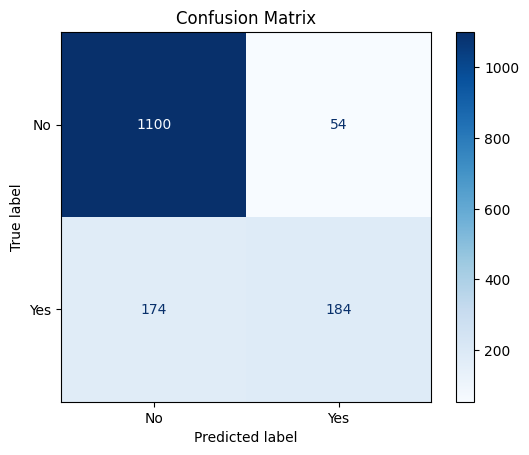

In [25]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [26]:
# The true positive rate (TPR)
print("True Positive Rate (TPR): ", recall_score(y_test, y_pred, pos_label='Yes'))


True Positive Rate (TPR):  0.5139664804469274



#### Feature importances
To obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their original input variables, not the one-hot encoded ones. We don't need to do this for the numeric variables because we didn't modify their names in any way.  
Note that we went from categorical features to one-hot encoded features, using the 'cat' column transformer.
 
Let's get all of the feature importances and associate them with their transformed features

In [27]:
# Extract feature importances
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_


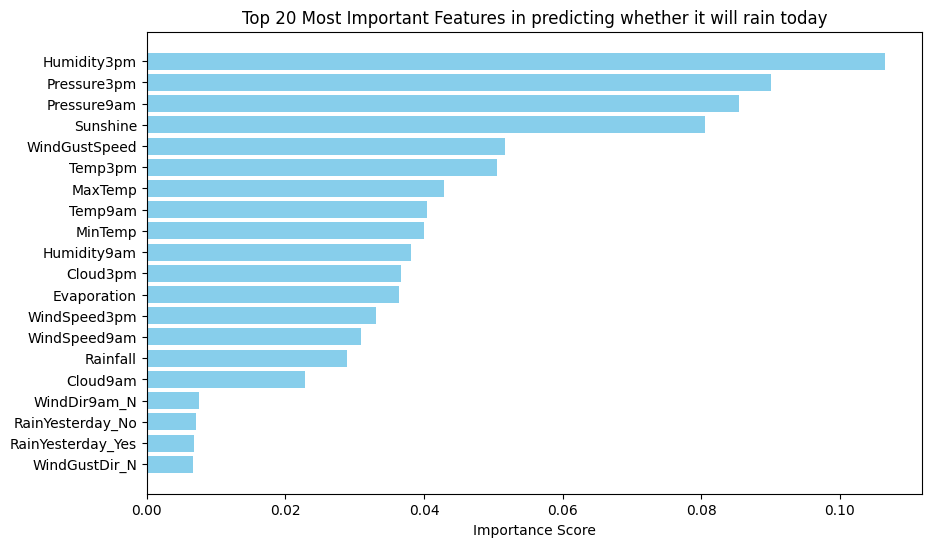

In [28]:
# Extract the feature importances and plot them as a bar graph.
# Combine numeric and categorical feature names
feature_names = numeric_features + list(
    grid_search.best_estimator_['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [29]:
# Try a different model

# Replace Random Forest for Logistic Regression

pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

#### Compare the results to previous model

In [30]:
# Compare results

print(classification_report(y_test, y_pred), "\n")

# Print best parameters found
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))



              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512
 


Best parameters found:  {'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.83


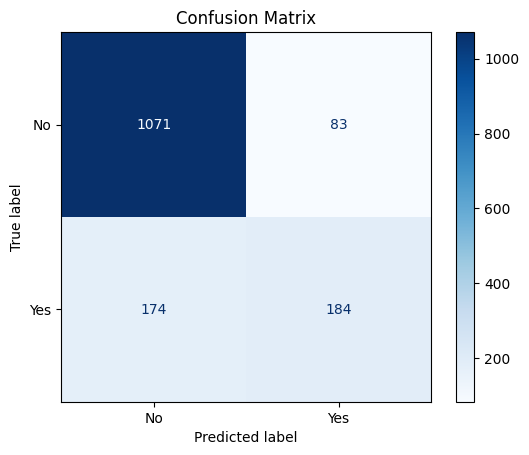

In [31]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The accuracy of the LogisticRegreesion is 0.83 indicating for every 100 classifications, 83 are aexpecteed to be correct. On the other hand, the accuracy for Random Forest Classifier is 0.84 indicating for every 100 classifications, 83 are expecteed to be correct. Therefore, the Random Forest Classifier had a better accuracy.
The True positive rate of the Logistic Regression model was 0.51 while it was 0.50 for the Random Forest model which means that the Logistic Regression model would be correct more times when it rains.
